# Annual Extremes

```{glue:figure} return_curve
:align: center
```

In this notebook, we’ll look at the highest annual water levels and how often they occur, using a statistical approach called extreme value theory. We'll then be able to put these highest water levels (and modeled 1-year, 2-year, and 10-year events) in context with the [rankings](notebooks/regional_and_local/SL_Rankings_annual.ipynb) we developed earlier. We’ll use the Generalized Extreme Value (GEV) distribution to model these extreme events. The GEV distribution helps us describe the largest values in a dataset using three main parameters:

- Location ($\mu$): where the center of the distribution is (similar to the average).
- Scale ($\Psi$): how spread out the values are.
- Shape ($\xi$): how the extremes behave at the tails (how likely very rare events are).

For this analysis, we’ll assume the overall pattern of water levels doesn’t change over time (this is called _stationarity_). This means we use past data to predict future extremes, assuming the underlying conditions stay the same. However, in reality, things like sea level rise, land movement, and climate cycles (like ENSO or PDO) can change these patterns over time. If you’re interested in how changing conditions affect extremes, see the [non-stationary extremes](notebooks/nonstationaryGEV/monthly_extremes_non-stationaryGEV.ipynb) notebook. For now, we’ll keep it simple and focus on the stationary case, using data that’s been adjusted to remove long-term trends.

## Setup
As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called [setup](notebooks/0_1_setup.ipynb) and import our plotting functions, which will also set our data and output paths. If you have not run the [datawrangling notebook](notebooks/SL_Data_Wrangling.ipynb), you will need to do this before running this notebook. 

In [3]:
%run ../0_1_setup.ipynb
import sys, pathlib
sys.path.append(str(pathlib.Path('../../functions').resolve()))
import tseries_functions as tsf

# import utide
from scipy.interpolate import interp1d


# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_daily_hawaii.nc').exists():
    print(f'rsl_daily_hawaii.nc not found in {data_dir}. Please run the data wrangling notebook first')
else:
    print(f'rsl_daily_hawaii.nc found in {data_dir}. Proceed.')


# check to make sure that data_dir/rsl_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_hawaii_noaa.nc').exists():
    print(f'rsl_hawaii_noaa.nc not found in {data_dir}. Please run the data wrangling notebook first')
else:
    print(f'rsl_hawaii_noaa.nc found in {data_dir}. Proceed.')

Using custom paths from config_env.py
Data directory: /Users/jfiedler/Projects/SL_Indicators/data
Output directory: /Users/jfiedler/Projects/SL_Indicators/output
rsl_daily_hawaii.nc found in /Users/jfiedler/Projects/SL_Indicators/data. Proceed.
rsl_hawaii_noaa.nc found in /Users/jfiedler/Projects/SL_Indicators/data. Proceed.


## Obtain Daily and Hourly datasets

In [4]:
#import rsl_daily

with xr.open_dataset(data_dir/ 'rsl_daily_hawaii.nc') as ds:

    #make rsl_daily a subset - do not include TGs with more than 25% NaNs
    data_coverage = ds['rsl_mhhw'].count(dim='time')/len(ds.time)

    #drop all locations with data_coverage less than 80%
    rsl_daily = ds.where(data_coverage>0.80,drop=True)

with xr.open_dataset(data_dir/ 'rsl_hawaii_noaa.nc') as ds:
    rsl_hourly = ds.sel(station_id = rsl_daily.station_id.values)
    

# truncate time period to end at the end of 2025
rsl_daily = rsl_daily.sel(time = slice(None, '2025-01-01'))
rsl_hourly = rsl_hourly.sel(time = slice(None, '2025-01-01'))

# check the last time in rsl_daily and rsl_hourly
print(rsl_daily.time[-1].values)
print(rsl_hourly.time[-1].values)

# check start time
print(rsl_daily.time[0].values)
print(rsl_hourly.time[0].values)

2024-12-29T12:00:00.000000000
2024-12-31T23:00:00.000000000
1993-01-02T12:00:00.000000000
1914-01-01T10:00:00.000000000


## Pre-process the data
### Remove outliers and obtain trend
Here we are using the FULL data set, not just from 1993-onward.

First we'll nan out the tsunami time periods, and then calculate the trend. Tsunami data is obtained from {cite:t}{`ncei_tsunami`}. 

In [5]:
# Fetch tsunami event data for Hawaii from NOAA API
url = "https://www.ngdc.noaa.gov/hazel/hazard-service/api/v1/tsunamis/events?itemsPerPage=200&page=1&regionCode=80"

response = requests.get(url)
data = response.json()

# Convert to DataFrame
events = pd.DataFrame(data['items'])

# remove events that do not have 'month' or 'day' or 'hour' columns
events = events.dropna(subset=['month', 'day', 'hour'])

# # Let's use 'year', 'month', 'day', 'hour', 'minute' for start time
def parse_event_time(row):
    # Some events may not have hour/minute
    year, month, day = row['year'], row['month'], row['day']
    hour = row.get('hour', 0) or 0
    minute = row.get('minute', 0) or 0
    return pd.Timestamp(year=int(year), month=int(month), day=int(day), hour=int(hour), minute=int(minute))

# Build a list of start times (you can add a fixed window, e.g., 36 hours, for each event)
tsunami_periods = []
for _, row in events.iterrows():
    try:
        start = parse_event_time(row)
        end = start + pd.Timedelta(hours=36)  # 36 hours to match previous analysis
        tsunami_periods.append((start, end))
    except Exception as e:
        print(f"Could not parse event: {e}")



# Manually add on 2021 Alaska, 2022 Tonga, 2011 Tohoku, 1960 Chile, 1964 Alaska
tsunami_periods.append((pd.Timestamp("2021-07-29"), pd.Timestamp("2021-07-30 12:00")))
tsunami_periods.append((pd.Timestamp("2022-01-15"), pd.Timestamp("2022-01-16 12:00")))
tsunami_periods.append((pd.Timestamp("2011-03-11"), pd.Timestamp("2011-03-12 12:00")))
tsunami_periods.append((pd.Timestamp("1960-05-22"), pd.Timestamp("1960-05-23 12:00")))
tsunami_periods.append((pd.Timestamp("1964-03-27 12:00"), pd.Timestamp("1964-03-29")))


Let's save a copy of rsl_hourly WITH tsunamis in it for our top 10 events:

In [6]:
rsl_hourly_with_tsunamis = rsl_hourly.copy()

Now we'll mask our tsunami periods (fill with nan) so that they don't affect our GEV distributions.

In [7]:
for start, end in tsunami_periods:
    rsl_hourly['sea_level'].loc[dict(time=slice(start, end))] = np.nan

Now we'll adjust our data to MHHW datum, and calculate the trend so that we can remove it from our analysis.

In [8]:
from pyextremes import get_extremes, get_return_periods, plotting, EVA

# cut data off at end of 2024
rsl_hourly = rsl_hourly.sel(time=slice(None, '2024-12-31'))

rsl_hourly['sea_level_mhhw'] = rsl_hourly['sea_level'] - rsl_hourly['MHHW']

# get trend, trend_rate, trend_mag
trend_mag, trend_line, trend_rate = tsf.process_trend_with_nan(rsl_hourly['sea_level_mhhw'])

Processing xarray DataArray (vectorized polyfit, time in years)...


Make a plot to make sure we're looking at the right thing.

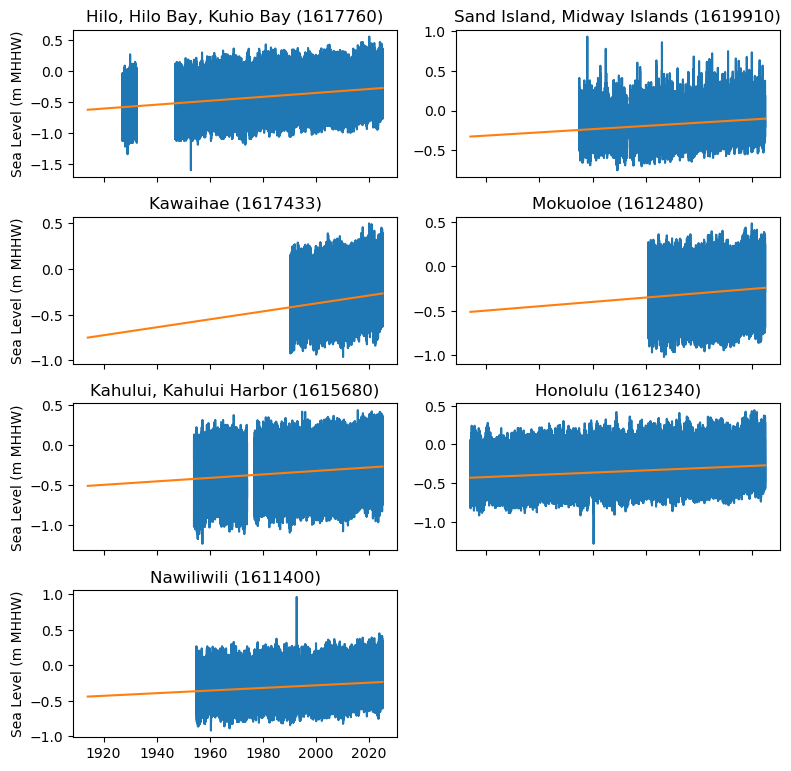

In [9]:
g = rsl_hourly['sea_level_mhhw'].plot(x='time', col='station_id', col_wrap=2, sharey=False, sharex=True, figsize=(8, 8))

# Use g.axs to iterate over the axes in the FacetGrid
for ax, sid in zip(g.axs.flat, rsl_hourly.station_id):
    # Accessing the station_name coordinate for the current station_id directly
    trend_line.sel(station_id = sid).plot(ax = ax)
    station_name = rsl_hourly['station_name'].sel(station_id = sid).values
    sid_str = str(sid.values)
    ax.set_title(f"{station_name} ({sid_str})")
    ax.set_xlabel('')
    ax.set_ylabel('Sea Level (m MHHW)')

    # remove ylabel if plot on the right
    # g.axs.shape gives (nrow, ncol)
    ncol = g.axs.shape[1]
    idx = np.where(g.axs.flat == ax)[0][0]
    if (idx % ncol) == (ncol - 1):
        ax.set_ylabel('')

plt.show()


Now we'll turn this data into a timeseries and detrend it (remove the trend line calculated above). This now puts everything relative to mean sea level for the calculated time period. Eventually we'll set it back to MHHW (NTDE 83-01 epoch).


In [10]:
#remove the linear trend, this will put everything at MSL.
rsl_detrended = rsl_hourly['sea_level_mhhw']-trend_line

Next we'll create an xarray full of zeros, so that we can later fill it up with values for our return periods at each station:

In [11]:
# Create a zero xarray
z = np.zeros((len(rsl_hourly['station_id'].values), 4))
return_periods = [2,10,50,100]
return_period_xr = xr.DataArray(z, coords=[rsl_hourly['station_id'].values, return_periods],
                  dims=['station_id', 'return period'])


Next, we'll turn each detrended sea level record into a pandas dataseries for extreme value analysis. This extra formatting step is necessary to ensure that the timesteps are handled correctly. Then we'll set everything relative to MHHW again.

For now, we'll pick a station to highlight. We'll choose Nawiliwili on Kauai.

Text(0, 0.5, 'Water Level (m, MHHW)\nLinearly Detrended')

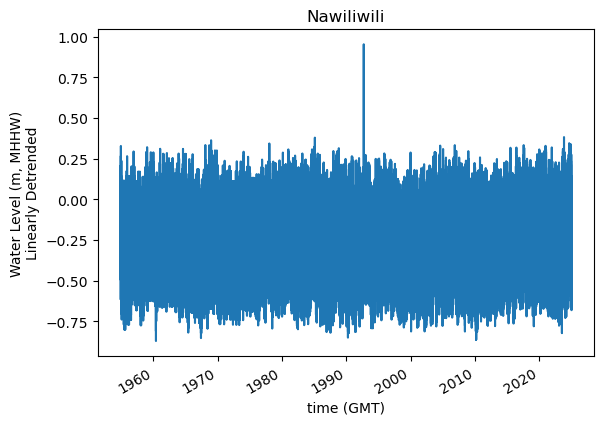

In [34]:
name = 'Nawiliwili'
# find the index of the station with this name
idx = np.where(rsl_hourly['station_name'].values == name)[0][0]
station_name = rsl_hourly['station_name'][idx].item()
station_id = rsl_hourly['station_id'][idx].item()
glue('station_name',station_name,display=False)

def convert_to_detrendedMHHW(idx: int):   
    sea_level_data_detrended = pd.Series(rsl_detrended[idx], index=pd.to_datetime(rsl_hourly['time'].values))
    sea_level_data = pd.Series(rsl_hourly['sea_level_mhhw'][idx], index=pd.to_datetime(rsl_hourly['time'].values))

    N = 360  # minimum number of valid points per year (adjust as needed)
    std_threshold = 0.05

    grouped = sea_level_data_detrended.groupby(sea_level_data_detrended.index.year)
    valid_years = [
        year for year, group in grouped
        if group.count() >= N and group.std() >= std_threshold
    ]
    sea_level_data_detrended = sea_level_data_detrended[sea_level_data_detrended.index.year.isin(valid_years)]

    # drop the nan values
    sea_level_data_detrended = sea_level_data_detrended.dropna()
    sea_level_data = sea_level_data.dropna()

    # set everything relative to MHHW from MSL coordinates
    MSLtoMHHW = np.round(rsl_hourly['MSL'][idx].values-rsl_hourly['MHHW'][idx].values,4)
    MSLtoMHHW

    sea_level_data_detrended = sea_level_data_detrended + MSLtoMHHW
    # label the data
    sea_level_data_detrended.name = 'sea level [m MHHW, detrended]'
    sea_level_data_detrended.index.name = 'time (GMT)'
    return sea_level_data_detrended
    # plot sea_level_data_detrended

sea_level_data_detrended =  convert_to_detrendedMHHW(idx)   



ax = sea_level_data_detrended.plot() # This should be in MHHW datum, check to see if it makes sense.

# add title
ax.set_title(station_name)
ax.set_ylabel('Water Level (m, MHHW)\nLinearly Detrended')

## Create the model, and extract the extreme values.
Here, we are going to find extremes using the Block Maxima (BM) method. This will find all extreme values by selecting a block size (here we've chosen a year for the annual max, and 30 days for the monthly max). 

In [13]:
# Here are a few functions to help with the analysis

def safe_idxmax(x):
    if x.dropna().empty:
        return pd.NaT
    return x.idxmax()

def get_BM_values(sea_level_data_detrended, timescale= 'YE'):
    BM_times = sea_level_data_detrended.resample(timescale).apply(safe_idxmax).dropna()
    BM_values = sea_level_data_detrended.loc[BM_times]
    BM_values.index = BM_times.index  # Set index to year-end for consistency
    # If you want the actual timestamp as index:
    BM_actual = pd.Series(BM_values.values, index=BM_times.values)
    if timescale == 'YE':
        BM_actual.name = 'Annual Maxima'
    elif timescale == 'ME':
        BM_actual.name = 'Monthly Maxima'
    return BM_actual





In [14]:
min_last_block_ratio = 0.9
BM = get_BM_values(sea_level_data_detrended)
model = EVA(BM)
model.get_extremes(extremes_type='high', method='BM', block_size='365D',min_last_block=min_last_block_ratio, errors='ignore')

/Users/jfiedler/anaconda3/envs/SLI311/lib/python3.11/site-packages/pyextremes/extremes/block_maxima.py:138: NoDataBlockWarning: 11 blocks contained no data
  warnings.warn(


Take a look at the extreme events, here calculated with BM method.

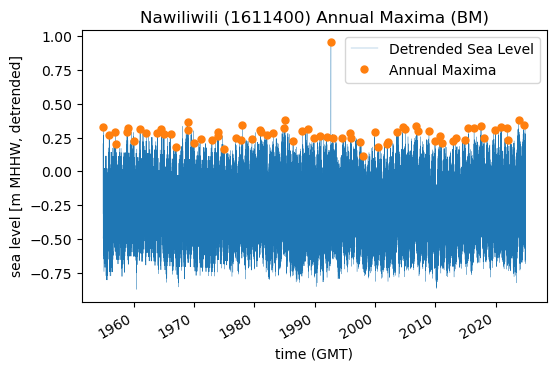

In [15]:
# Plot the annual maxima (BM) as a time series
fig, ax = plt.subplots(figsize=(6, 4))
#plot sea_level_detrended
sea_level_data_detrended.plot(ax=ax, linestyle='-', label='Detrended Sea Level', linewidth=0.2)
BM.plot(ax=ax, marker='o', linestyle='', label='Annual Maxima', markersize=5)
ax.set_xlabel('time (GMT)')
ax.set_ylabel('sea level [m MHHW, detrended]')
ax.legend()
ax.title.set_text(f'{station_name} ({station_id}) Annual Maxima (BM)')

## Fit the model
We are going to take our extremes and fit them to a model. The pyextremes package will select the 'best model' for this using the Akaike Information Criterion (AIC), with the goal of losing the least amount of information in a given model. Using BM, we could have either a GEV or a Gumbel (specialized case of the GEV) distribution. While we could force it to either distribution, for this case we'll the AIC play out.

In [16]:
model.fit_model()

distribution_name = model.distribution.name
if distribution_name == 'genextreme':
    distribution_name = 'GEV'
    
glue("distribution name", model.distribution.name, display=False)


Here, we are using the {glue:text}`distribution name` distribution. Now, we'll print out the shape, location, and scale parameters. 

If we are using the GEV distribution, we'll have 3 parameters (shape, scale, and location) using the Maximum Likelihood Estimation (MLE). 
If we are using the gumbel distribution, there are only 2 free parameters: location and scale (as the GEV approaches Gumbel when the shape parameter goes to zero.)

In [17]:
if model.distribution.name == 'gumbel_r':
    shape = 0
else:
    shape = model.distribution.mle_parameters['c']
scale = model.distribution.mle_parameters['scale']
loc = model.distribution.mle_parameters['loc']

# Format with two decimal places
shape_str = f'{shape:.2f}'
scale_str = f'{scale:.2f}'
loc_str = f'{loc:.2f}'

glue("shape", shape_str, display=False)
glue("scale", scale_str, display=False)
glue("loc", loc_str, display=False)


For the {glue:text}`station_name` tide gauge, the shape parameter $\xi$ is {glue:text}`shape`, corresponding to a {glue:text}`distribution name` distribution of the extremes. The location parameter $\mu$ tells us that the distribution is centered around {glue:text}`loc`, and the scale parameter ($\psi$  = {glue:text}`scale`} shows how tightly the extremes cluster with each other (little dispersion).

### Let's get a closer look at the return level curve


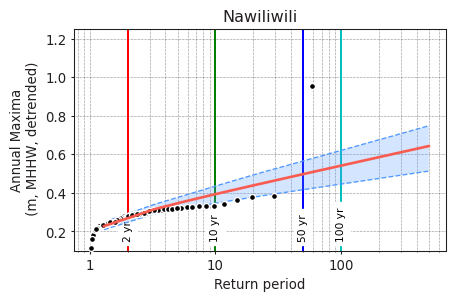

In [18]:
def plot_returnLevelCurve(sid):
    fig,ax = model.plot_return_values(alpha=0.95, return_period=np.arange(1.3,500,2),n_samples=1000, plotting_position='weibull')
    ax.set_ylim(0.1,1.25)

    # add lines for the 2, 5, 10, 50, and 100 year return periods
    return_periods = [2,10,50,100]

    colors = ['r','g','b','c']
    for return_period, color in zip(return_periods, colors):
        ax.axvline(x=return_period, color=color, label=f'{return_period} year return period')
        ax.text(return_period, 0.15, f'{return_period} yr', rotation=90, 
            verticalalignment='bottom',backgroundcolor='w',horizontalalignment='center',
            fontsize=8)

    fig.set_size_inches(5,3)
    ax.set_title(station_name)
    ax.set_ylabel('Annual Maxima\n (m, MHHW, detrended)')
    # save the figure
    figname = 'SL_extremes_return_values_'+ station_name + '.png'
    plt.savefig(output_dir / figname, dpi=300, bbox_inches='tight')
    plt.show()
    return fig, ax

fig, ax = plot_returnLevelCurve(sid)

glue('return_curve', fig, display=False)

```{glue:figure} return_curve
:name: "return_curve"

Return level curve for {glue:text}`station_name`, using annual maxima (block maxima method). The 2,10, 50 and 100 yr periods are shown as vertical lines. Confidence intervals for the GEV model are shown in shaded blue. Note that the extreme annual maximum (almost 1m above MHHW) does not fall neatly on this distribution. In this case, this extreme is the result of exception water levels due to the landfall of Hurricane Iniki in 1992. Hurricane landfalls are rare events in Hawaii, and thus it should be expected that an event like this does not align with distributions made with our historical observations.
```



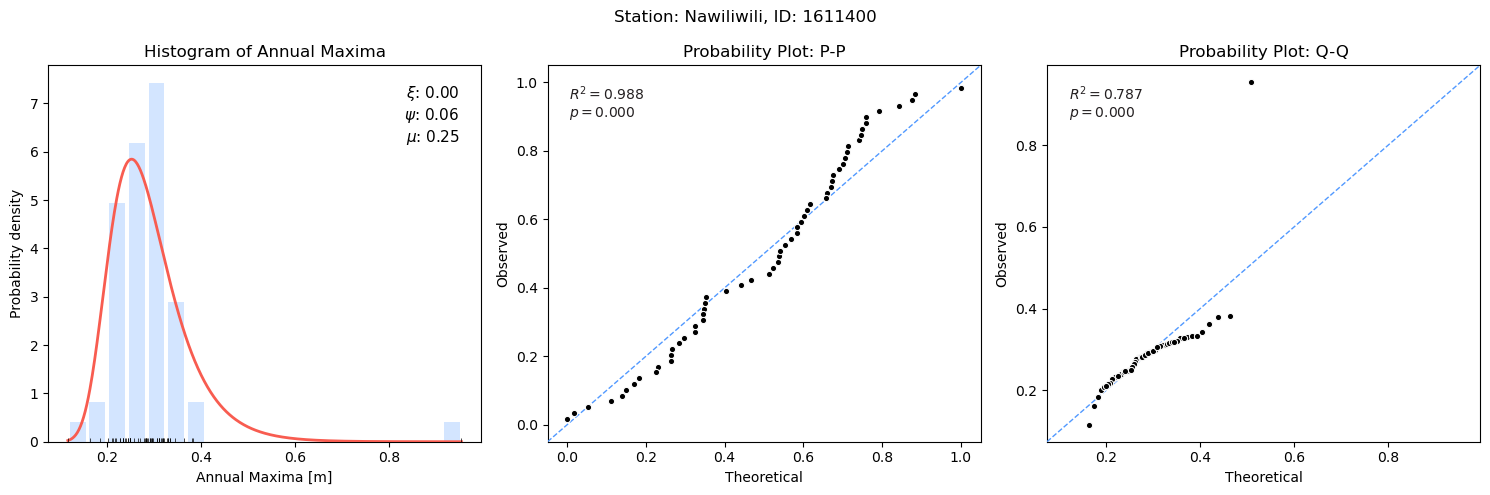

In [19]:
def plot_stats(sid):
    # make new figure with axes 1-3
    fig, axs = plt.subplots(1,3, figsize=(15,5))

    # make pdf of extremes
    pdf_extremes = np.linspace(model.extremes.min(), model.extremes.max(), 500)
    pdf = model.model.pdf(model.extremes_transformer.transform(pdf_extremes))

    axs[0].hist(
                model.extremes.values,
                bins=np.histogram_bin_edges(a=model.extremes.values, bins=20),
                density=True,
                rwidth=0.8,
                facecolor="#5199FF",
                edgecolor="None",
                lw=0,
                alpha=0.25,
                zorder=5,
            )

    axs[0].plot(pdf_extremes, pdf, color="#F85C50", lw=2, ls="-", zorder=15)

    axs[0].scatter(
                model.extremes.values,
                np.full(shape=len(model.extremes), fill_value=0),
                marker="|",
                s=40,
                color="k",
                lw=0.5,
                zorder=15,
            )

    # add parameters to the plot
    axs[0].text(
        0.95,
        0.95,
        f"$\\xi$: {shape_str}\n$\\psi$: {scale_str}\n$\\mu$: {loc_str}",
        fontsize=11,
        ha="right",
        va="top",
        transform=axs[0].transAxes  # Updated to 'axs.transAxes' assuming axs is a single axis object
    )


    axs[0].set_xlabel('Annual Maxima [m]')
    axs[0].set_ylabel("Probability density")

    model.plot_probability('PP',ax=axs[1])
    model.plot_probability('QQ',ax=axs[2])

    axs[0].set_title('Histogram of Annual Maxima')
    axs[1].set_title('Probability Plot: P-P')
    axs[2].set_title('Probability Plot: Q-Q')
    fig.tight_layout()

    # add a supertitle with station name and station id
    fig.suptitle(f'Station: {station_name}, ID: {sid.values}', fontsize=12)

    # move other stuff down
    axs[0].set_title('Histogram of Annual Maxima')
    axs[1].set_title('Probability Plot: P-P')
    axs[2].set_title('Probability Plot: Q-Q')
    fig.tight_layout()

    # save the figure
    figname = 'SL_extremes_histogram_pp_qq_'+ station_name + '.png'

    plt.savefig(output_dir / figname, dpi=300, bbox_inches='tight')

plot_stats(sid)

### Get return periods of 2, 10, 50 and 100 years

In [20]:
# Get summary of the model
return_periods=[2,5, 10, 50, 100]

summary = model.get_summary(
    return_period=return_periods,
    alpha=0.95, n_samples=1000
)

#change name "return period" to "return period (yrs)"
summary = summary.rename(columns={'return period': 'return period (yrs)','return value':'Water Level (m, MHHW)','lower ci':'Lower CI (m, MHHW)','upper ci':'Upper CI (m, MHHW)'})
summary


,"Water Level (m, MHHW)","Lower CI (m, MHHW)","Upper CI (m, MHHW)"
return period,,,
2.0,0.274906,0.257933,0.293540
5.0,0.346225,0.313980,0.376264
10.0,0.393450,0.346571,0.435037
50.0,0.497390,0.416226,0.564938
100.0,0.541332,0.445722,0.619946


In [21]:
# get return periods (2,5, 10,50,100) for all stations:
stat_names = ['Water Level (m, MHHW)', 'Lower CI (m, MHHW)', 'Upper CI (m, MHHW)']

# Create an empty DataArray with dimensions: station_id, return period, stat
z = np.zeros((len(rsl_hourly['station_id'].values), len(return_periods), len(stat_names)))
return_period_xr = xr.DataArray(
    z,
    coords={
        'station_id': rsl_hourly['station_id'].values,
        'return period': return_periods,
        'stat': stat_names
    },
    dims=['station_id', 'return period', 'stat']
)

if not (output_dir / 'return_period_stationary_CI.nc').exists():
    for rec_id in np.arange(0, len(rsl_daily['station_id']), 1):
        sea_level_data_detrended_temp = convert_to_detrendedMHHW(rec_id)
        min_last_block_ratio = 0.9
        BM = get_BM_values(sea_level_data_detrended_temp)
        model = EVA(BM)
        model.get_extremes(extremes_type='high', method='BM', block_size='365D', min_last_block=min_last_block_ratio, errors='ignore')
        model.fit_model()
        summary = model.get_summary(
            return_period=return_periods,
            alpha=0.95, n_samples=1000
        )
        summary = summary.rename(columns={
            'return period': 'return period (yrs)',
            'return value': 'Water Level (m, MHHW)',
            'lower ci': 'Lower CI (m, MHHW)',
            'upper ci': 'Upper CI (m, MHHW)'
        })

        # Assign the values for each stat
        for i, stat in enumerate(stat_names):
            return_period_xr[rec_id, :, i] = summary[stat].values

        # Save to NetCDF
        return_period_xr.to_netcdf(output_dir / 'return_period_stationary_CI.nc')
else:
    print('return_period_stationary_CI.nc already exists, skipping calculation.')
    return_period_xr = xr.open_dataarray(output_dir/ 'return_period_stationary_CI.nc')


return_period_stationary_CI.nc already exists, skipping calculation.


### Make an intergrated rankings + return periods table

First, import some functions to get the top 10 ranked recorded water levels. The same are used in the rankings notebook.

In [22]:
import sys, pathlib
sys.path.append(str(pathlib.Path('../../functions').resolve()))
from ranking import get_top_ten, get_top_10_table

### First make the rankings list

In [23]:

rsl_subset = rsl_hourly_with_tsunamis.copy()
rsl_subset['sea_level'] = rsl_subset['sea_level'] - rsl_subset['MHHW']

SL_rankings10 = get_top_10_table(rsl_subset,station_id, oni_path=str(data_dir / 'climate_indices' / 'oni.csv'))

# take only the max type
SL_rankings10 = SL_rankings10[SL_rankings10['type']=='max']
SL_rankings10

,rank,date,sea level (m),station_name,station_id,type,ONI,ONI Mode
0,1,1992-09-12 02:00:00,0.964,Nawiliwili,1611400,max,-0.13,Neutral
1,2,2023-10-30 15:00:00,0.451,Nawiliwili,1611400,max,1.78,El Nino
2,3,2024-08-20 02:00:00,0.415,Nawiliwili,1611400,max,-0.11,Neutral
3,4,2024-11-16 14:00:00,0.409,Nawiliwili,1611400,max,-0.37,Neutral
4,5,2020-12-15 15:00:00,0.392,Nawiliwili,1611400,max,-1.19,La Nina
5,6,2017-07-23 02:00:00,0.390,Nawiliwili,1611400,max,0.14,Neutral
6,7,2021-12-05 15:00:00,0.384,Nawiliwili,1611400,max,-0.98,La Nina
7,8,2023-08-30 01:00:00,0.378,Nawiliwili,1611400,max,1.32,El Nino
8,9,1985-02-04 14:00:00,0.376,Nawiliwili,1611400,max,-0.85,La Nina
9,10,2024-08-31 00:00:00,0.374,Nawiliwili,1611400,max,-0.11,Neutral


Now we'll add in the return period table

In [24]:
# mix this dataframe in with the SL_rankings table:

# extract only 'Highest' and 'Highest Date' columns
SL_rankings = SL_rankings10[['date','sea level (m)']]

#rename 'Highest' to sea level (m, MHHW)
SL_rankings = SL_rankings.rename(columns={'sea level (m)':'Water Level (m, MHHW)'})

# Ensure 'Water Level (m, MHHW)' column is numeric for both DataFrames
SL_rankings['Water Level (m, MHHW)'] = pd.to_numeric(SL_rankings['Water Level (m, MHHW)'], errors='coerce')
summary['Water Level (m, MHHW)'] = pd.to_numeric(summary['Water Level (m, MHHW)'], errors='coerce')

# Merge the SL_rankings DataFrame with the summary DataFrame on 'water level (m, MHHW)'
SL_rankings_merge = pd.merge(SL_rankings, summary.reset_index(), on='Water Level (m, MHHW)', how='outer')

SL_rankings_merge = SL_rankings_merge.sort_values('Water Level (m, MHHW)',ascending=False)

SL_rankings_merge['Date or Return Period'] = SL_rankings_merge.apply(
    lambda row: row['date'] if pd.notnull(row['date']) else row['return period'], axis=1
)

SL_rankings_merge = SL_rankings_merge.drop(columns=['date','return period','Lower CI (m, MHHW)','Upper CI (m, MHHW)'])
# SL_rankings_merge = SL_rankings_merge.drop(columns=['date','return period'])


# Add a column for feet
SL_rankings_merge['Water Level (ft, MHHW)'] = SL_rankings_merge['Water Level (m, MHHW)']*3.28084

# Rearrange columns to Date or Return Period, water level (m, MHHW), water level (ft, MHHW)
SL_rankings_merge = SL_rankings_merge[['Date or Return Period','Water Level (m, MHHW)','Water Level (ft, MHHW)']]


In [25]:
SL_rankings_merge

,Date or Return Period,"Water Level (m, MHHW)","Water Level (ft, MHHW)"
14,1992-09-12 02:00:00,0.964000,3.162730
13,100.0,0.541332,1.776023
12,50.0,0.497390,1.631857
11,2023-10-30 15:00:00,0.451000,1.479659
10,2024-08-20 02:00:00,0.415000,1.361549
9,2024-11-16 14:00:00,0.409000,1.341864
8,10.0,0.393450,1.290847
7,2020-12-15 15:00:00,0.392000,1.286089
6,2017-07-23 02:00:00,0.390000,1.279528
5,2021-12-05 15:00:00,0.384000,1.259843


### Format the merged rankings and return period table

In [26]:
# Format the date to be in the format 'YYYY-MM-DD' if a date, or '10-year flood' if a return period
SL_rankings_merge['Date or Return Period'] = SL_rankings_merge['Date or Return Period'].apply(
    lambda x: x.strftime('%Y-%m-%d') if isinstance(x, pd.Timestamp) else f'{int(x)}-year flood' if isinstance(x, (int, float)) else x
)

# Format the water level columns to have 2 decimal places
SL_rankings_merge['Water Level (m, MHHW)'] = SL_rankings_merge['Water Level (m, MHHW)'].round(2)
SL_rankings_merge['Water Level (ft, MHHW)'] = SL_rankings_merge['Water Level (ft, MHHW)'].round(2)

# export the table to a csv file
csvname = 'SL_extremes_' + station_name + '.csv'
SL_rankings_merge.to_csv(output_dir / csvname, index=False)


SL_rankings_merge

,Date or Return Period,"Water Level (m, MHHW)","Water Level (ft, MHHW)"
14,1992-09-12,0.96,3.16
13,100-year flood,0.54,1.78
12,50-year flood,0.50,1.63
11,2023-10-30,0.45,1.48
10,2024-08-20,0.42,1.36
9,2024-11-16,0.41,1.34
8,10-year flood,0.39,1.29
7,2020-12-15,0.39,1.29
6,2017-07-23,0.39,1.28
5,2021-12-05,0.38,1.26


In [27]:
# make into a table with great_tables
from great_tables import GT, html, md

In [28]:
# make a copy of the DataFrame
SL_rankings_merge_copy = SL_rankings_merge.copy()

# replace all spaces with underscores in top_10_display column names
# SL_rankings_merge_copy.columns = SL_rankings_merge_copy.columns.str.replace(' ', '_')

# replace column names 
SL_rankings_merge_copy.columns = ['Date_or_Return_Period', 'mMHHW', 'ftMHHW']


In [29]:
# Convert the DataFrame to a great_table
tablename = "SL_rankings_merge_" + station_name + ".png"
savepath = output_dir / tablename

(
    GT(SL_rankings_merge_copy)
    .tab_header(title='Highest Sea Level Events', subtitle='Station: '+ station_name + '(' + str(station_id) + ')')
    .cols_align('center')
    .cols_label(Date_or_Return_Period=html("Date or <br>Return Period"), mMHHW=html('Water Level <br>(m, MHHW)'),ftMHHW = html('Water Level <br>(ft, MHHW)'))
    .tab_source_note(source_note='Source: NOAA CO-OPS Hourly Water Level')
    .save(savepath)
)

GT(_tbl_data=   Date_or_Return_Period  mMHHW  ftMHHW
14            1992-09-12   0.96    3.16
13        100-year flood   0.54    1.78
12         50-year flood   0.50    1.63
11            2023-10-30   0.45    1.48
10            2024-08-20   0.42    1.36
9             2024-11-16   0.41    1.34
8          10-year flood   0.39    1.29
7             2020-12-15   0.39    1.29
6             2017-07-23   0.39    1.28
5             2021-12-05   0.38    1.26
4             2023-08-30   0.38    1.24
3             1985-02-04   0.38    1.23
2             2024-08-31   0.37    1.23
1           5-year flood   0.35    1.14
0           2-year flood   0.27    0.90, _body=<great_tables._gt_data.Body object at 0x1a3ce9290>, _boxhead=Boxhead([ColInfo(var='Date_or_Return_Period', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Date or <br>Return Period'), column_align='center', column_width=None), ColInfo(var='mMHHW', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Water Level <br>(m, MHHW)'), column_align='center', column_width=None), ColInfo(var='ftMHHW', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Water Level <br>(ft, MHHW)'), column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x1a3cd8d50>, _spanners=Spanners([]), _heading=Heading(title='Highest Sea Level Events', subtitle='Station: Nawiliwili(1611400)', preheader=None), _stubhead=None, _source_notes=['Source: NOAA CO-OPS Hourly Water Level'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x1a3ce8450>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type

```{margin} EXPLAINER
Why is this table different from other similar tables? (For example, the [NASA flooding analysis tool](https://sealevel.nasa.gov/flooding-analysis-tool/observed-flooding?station-id=1617760&units=meters))

A couple of reasons why things might be different: 1) This table uses hourly data, which can "smooth out" the true maxima compared to 6-minute averages, and 2) uncertainty increases with longer return periods. When estimating rare events (like 50- or 100-year floods), our results are fundamentally limited by the length and variability of the historical record.
```

## Make a map
### Plot the Return Periods at each station
Note that we are neglecting the confidence intervals for now.

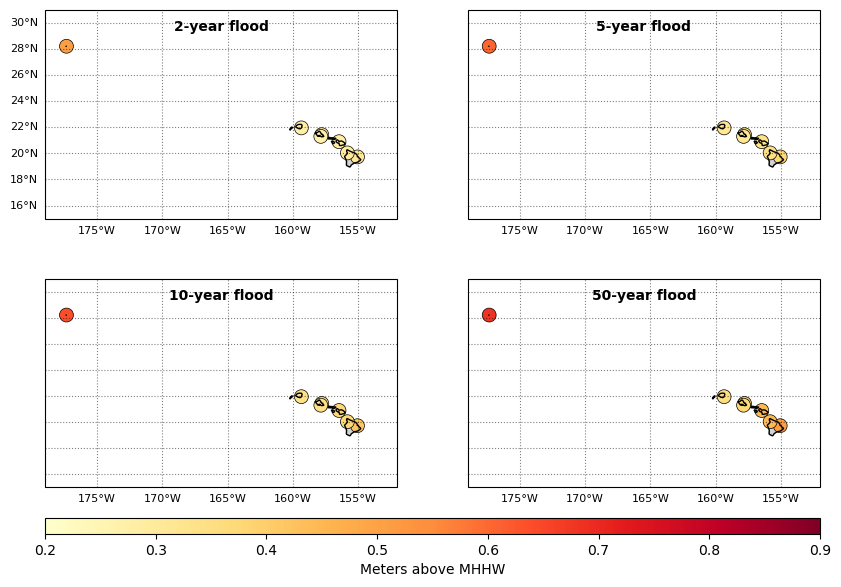

In [30]:
crs = ccrs.PlateCarree()
fig, axs = plt.subplots(2,2,figsize=(10, 8), subplot_kw={'projection': crs})
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in create_collection")

cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.125deg_1993_2025hawaii.nc')

xlims = [181, 208]
ylims = [15,31]


# plt.colorbar(maxplt,ax=axs[0],label='Sea Level (m)', location='bottom')           

for i, ax in enumerate(axs.flat):

    ax.scatter(rsl_hourly['lon'], rsl_hourly['lat'], transform=crs, s=100, 
               c=return_period_xr[:,i,0].values, vmin=0.2, vmax=0.9, cmap='YlOrRd',
               linewidth=0.5, edgecolor='black')
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')

    # set extent
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], crs=crs)

    #add grid
    gl = ax.gridlines(draw_labels=False, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    if i>=0:
        gl.bottom_labels = True

    if i==0:
        gl.left_labels = True

    #make all labels tiny
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # add text to top left of plot
    ax.text(0.5, 0.95, f'{return_periods[i]}-year flood', color='black', fontsize=10, weight='bold',
            transform=ax.transAxes, ha='center', va='top', zorder=10)

# add colorbar to the bottom of the plot which follows vmin, vmax and cmap of the scatter plot
# colorbar should be 
cbar = plt.colorbar(axs[1, 1].collections[0], ax=axs, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label('Meters above MHHW')

# save the figure
plt.savefig(output_dir / 'SL_extremes_map.png', dpi=300, bbox_inches='tight')

## Plot a timeseries

/Users/jfiedler/anaconda3/envs/SLI311/lib/python3.11/site-packages/pyextremes/extremes/block_maxima.py:138: NoDataBlockWarning: 11 blocks contained no data
  warnings.warn(
/Users/jfiedler/anaconda3/envs/SLI311/lib/python3.11/site-packages/pyextremes/extremes/block_maxima.py:138: NoDataBlockWarning: 11 blocks contained no data
  warnings.warn(


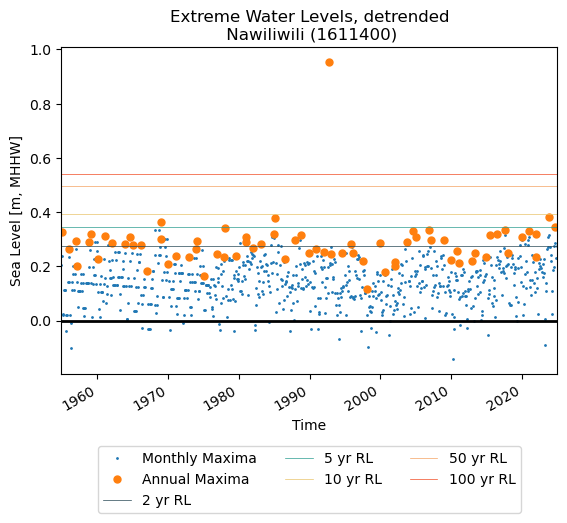

In [31]:
# plot the monthly maxima
# monthly_max = get_extremes(sea_level_data_detrended, method='BM', 
#                            extremes_type='high', block_size='30D', min_last_block=0.9, errors='ignore')
# annual_max = get_extremes(sea_level_data_detrended, method='BM', extremes_type='high', block_size='365.245D', min_last_block=0.9, errors='ignore')

BM_year = get_BM_values(sea_level_data_detrended)
BM_month = get_BM_values(sea_level_data_detrended, timescale='ME')
model = EVA(BM_year)
model.get_extremes(extremes_type='high', method='BM', block_size='365D',min_last_block=min_last_block_ratio, errors='ignore')


model.get_extremes(extremes_type='high', method='BM', block_size='365D',min_last_block=min_last_block_ratio, errors='ignore')

fig, ax = plt.subplots()
BM_month.plot(ax=ax, marker='.',linestyle='', label='Monthly Maxima', markersize=2)
BM_year.plot(ax=ax, marker='o', linestyle='', label='Annual Maxima', markersize=5)

ax.set_xlabel('Time')
ax.set_ylabel('Sea Level [m, MHHW]')
ax.set_title(f'Extreme Water Levels, detrended\n {station_name} ({station_id})')

colors = ['#264653',  # dark cyan
          '#2a9d8f',  # teal
          '#e9c46a',  # sandy yellow
          '#f4a261',  # sandy orange
          "#f14b22"]  # dark orange

# add the 2, 10, 50, and 100 year return levels in horizontal lines
for i,period in enumerate(return_periods):
    ax.axhline(summary.loc[period, 'Water Level (m, MHHW)'], label=f'{period} yr RL', color=colors[i],linewidth=0.5)

# add bold black line at 0 for MHHW
ax.axhline(0, color='black', linewidth=2)
ax.legend()
# put the legend at the bottom of the plot in one row
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
ax.set_xlim([sea_level_data_detrended.index[0], sea_level_data_detrended.index[-1]])

# save the figure
figname = 'SL_extremes_monthly_annual_maxima_' + station_name + '.png'
plt.savefig(output_dir / figname, dpi=300, bbox_inches='tight')

glue('fig', 'SL_extremes_timeseries', display=False)

```{glue:figure} SL_extremes_timeseries
:name: "SL_extremes_timeseries"

Extreme water levels at {glue:text}`station_name`, plotted with the background long-term trend removed. The 2,10,50, and 100 return levels are shown in blue, green, yellow and orange respectively. Both monthly and yearly maxima are obtained using the block maxima method. The GEV-derived stationary return levels are derived using the pyextremes python package. One key takeaway from this figure: removing the trend shows that we've had some significant events in the past that do not show up in our rankings. 
```

 

In [32]:
import plotly.graph_objects as go


fig = go.Figure()

# Add monthly maxima as a line
fig.add_trace(go.Scatter(x=BM_month.index, y=BM_month, mode='markers', name='Monthly Maxima', marker=dict(size=2)))

# Add annual maxima as scatter points
fig.add_trace(go.Scatter(x=BM_year.index, y=BM_year, mode='markers', name='Annual Maxima'))


colors = ['#264653',  # dark cyan
          '#2a9d8f',  # teal
          '#e9c46a',  # sandy yellow
          '#f4a261',  # sandy orange
          "#f14b22"]  # dark orange


# Add return levels as labeled lines
for i, period in enumerate(return_periods):
    fig.add_trace(go.Scatter(x=[BM_month.index.min(), BM_month.index.max()],
                             y=[summary.loc[period, 'Water Level (m, MHHW)']] * 2,
                             mode='lines',
                             line=dict(color=colors[i], width=1),
                             name=f'{period} year RL'))
    
# Add a bold black line at 0 for MHHW
fig.add_hline(y=0, line=dict(color='black', width=2))

# Set titles and labels
fig.update_layout(title=f'Extreme Water Levels, Stationary GEV: {station_name} ({station_id})',
                  xaxis_title='Time',
                  yaxis_title='Sea Level [m, MHHW, detrended]',
                  legend=dict(x=0.5, xanchor='center', y=-0.2, orientation='h', bgcolor='rgba(255,255,255,0.8)'),
                  plot_bgcolor='white',  # Set plot background to white
                  paper_bgcolor='white')  # Set overall background to white

# Set x-axis limits if needed
fig.update_xaxes(range=[BM_month.index.min(), BM_month.index.max()])
fig.update_layout(width=800, height=500,autosize=False)
# Show the figure
fig.show()

# save the figure
figname = 'SL_extremes_monthly_annual_maxima_' + station_name + '.html'

fig.write_html(output_dir / figname)

```{warning}
Is this interactive plot not showing up? Try the already made version [here](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/SL_extremes_monthly_annual_maxima_Nawiliwili.html).
```

## Citations

```{bibliography}
:style: plain
:filter: docname in docnames
```